In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation



In [154]:
x = pd.DataFrame(np.random.randn(500))

* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)

In [172]:
x_dom = np.linspace(-4,4,150)

def multigauss(domain,x):
    std = x.std()
    size = len(x)
    
    return np.array([  scs.norm.pdf(domain,xx,1.06*std*size**(-0.2)) for xx in x.values])


mg = multigauss(x_dom,x)

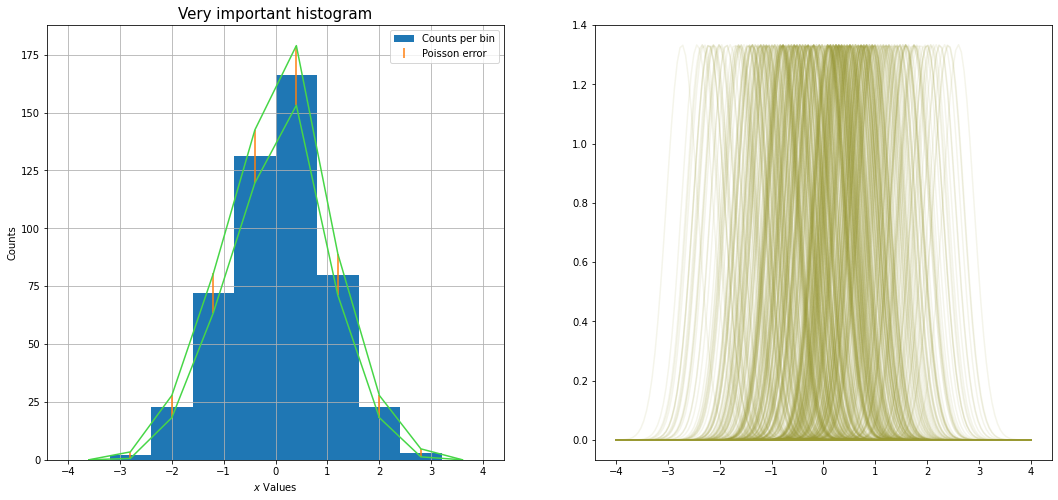

In [202]:
figure = plt.figure(figsize=(18,8))
axes1 = figure.add_subplot(1,2,1)
hy,hx,hpl = axes1.hist(x,bins=10,range=(-4,4),align="mid",label="Counts per bin")
hx = 0.5*(hx[:-1]+hx[1:])
axes1.errorbar(hx,hy,yerr=np.sqrt(hy),linestyle='',label="Poisson error")
axes1.plot(hx,hy+np.sqrt(hy),color=np.array([0.2,0.6,0.2])*1.4)
axes1.plot(hx,hy-np.sqrt(hy),color=np.array([0.2,0.6,0.2])*1.4)
axes1.set_ylabel("Counts")
axes1.set_xlabel("$x$ Values")
axes1.set_title("Very important histogram",size=15)
axes1.legend()
axes1.grid(True)

axes2 = figure.add_subplot(1,2,2)
for g in mg:
    axes2.plot(x_dom,g,alpha=0.1,color=[0.6,0.6,0.2])



* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot